In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch

resnet_model = torch.load('/content/drive/MyDrive/CSE8803_DLT/Resnet50_10epoch.pt')
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
!pip -q install transformers

In [ ]:
import transformers

bert_model = torch.load('/content/drive/MyDrive/CSE8803_DLT/berttweet_2epoch.pt')
bert_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
from torch.utils.data import (TensorDataset,DataLoader,
                             RandomSampler, SequentialSampler, Dataset)

def prepare_dataloaders(train_df,test_df,batch_size=64):
    # Load the AutoTokenizer with a normalization mode if the input Tweet is raw
    
    tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)
    
    tweet_train = bert_encode(train_df, tokenizer)
    tweet_train_labels = train_df['Sarcastic'].astype(int)
    
    tweet_test = bert_encode(test_df, tokenizer)

    input_ids, attention_masks = tweet_train.values()
    labels = torch.tensor(tweet_train_labels.values)
    train_dataset = TensorDataset(input_ids, attention_masks, labels)

    
    input_ids, attention_masks = tweet_test.values()
    test_dataset = TensorDataset(input_ids, attention_masks)

    
    train_dataloader = DataLoader(
                train_dataset,
                sampler = RandomSampler(train_dataset), 
                batch_size = batch_size 
            )


    test_dataloader = DataLoader(
                test_dataset, 
                sampler = SequentialSampler(test_dataset), 
                batch_size = batch_size
            )
    return train_dataloader, test_dataloader

In [ ]:
def predict(model,test_dataloader):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    preds = []

    for batch in test_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        for logit in logits:
            preds.append(logit)

    return np.array(preds)

In [ ]:
# Load data

import ast
import pandas as pd

def load_data_lists(path):
    data_points_lists = []
    with open(path, encoding='utf-8') as f:
        lines = f.readlines()

        for line in lines:
            try:
                data_points_lists.append(ast.literal_eval(line))
            except:
                # Ignore lines with errors
                pass

    print('Found {} lines in "{}".'.format(len(lines), path))
    print('Successfully loaded {} data points from "{}".'.format(len(data_points_lists), path))
    
    return data_points_lists

COLUMN_NAMES = ['ID', 'Text', 'Sarcastic']

def construct_df(data_points_lists, column_names=COLUMN_NAMES):
    df = pd.DataFrame(data_points_lists, columns=column_names)
    df['ID'] = pd.to_numeric(df['ID'])
    df['Sarcastic'] = df['Sarcastic'].astype('bool')
    
    return df

In [ ]:
train_df = construct_df(load_data_lists('train.txt'))

train_df.info()
train_df.head()

Found 29040 lines in "train.txt".
Successfully loaded 29040 data points from "train.txt".
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         29040 non-null  int64 
 1   Text       29040 non-null  object
 2   Sarcastic  29040 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 482.2+ KB


,ID,Text,Sarcastic
0,910308516510011393,most # funny quotes : 21 snarky and # funny qu...,True
1,725333760762363905,spurs # creativethinking ! <url>,True
2,840006160660983809,<user> thanks for showing up for our appointme...,True
3,854334602516733952,only a hardcore fan of sir jonny sins will get...,True
4,908913372199915520,haha . # lol,True


In [ ]:
valid_df = construct_df(load_data_lists('valid.txt'), column_names=COLUMN_NAMES + ['Sarc_2'])

valid_df.info()
valid_df.head()

Found 2410 lines in "valid.txt".
Successfully loaded 2410 data points from "valid.txt".
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         2410 non-null   int64 
 1   Text       2410 non-null   object
 2   Sarcastic  2410 non-null   bool  
 3   Sarc_2     2410 non-null   int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 59.0+ KB


,ID,Text,Sarcastic,Sarc_2
0,915657464401580032,whew ... that extra <num> miles today to the g...,True,1
1,854678856724340736,""" oh , good . now no one will know we 're here...",True,1
2,904892917277274112,how much of it you think is true ? has this be...,True,1
3,855466461296504832,<user> finally found proof that the earth is f...,True,1
4,927373534652805120,many ways to overcome tension & fear but nothi...,True,1


In [ ]:
test_df = construct_df(load_data_lists('test.txt'), column_names=COLUMN_NAMES + ['Sarc_2'])

test_df.info()
test_df.head()

Found 2409 lines in "test.txt".
Successfully loaded 2409 data points from "test.txt".
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409 entries, 0 to 2408
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         2409 non-null   int64 
 1   Text       2409 non-null   object
 2   Sarcastic  2409 non-null   bool  
 3   Sarc_2     2409 non-null   int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 58.9+ KB


,ID,Text,Sarcastic,Sarc_2
0,862902619928506372,i am guessing # netflix no longer lets you gra...,True,1
1,892551658487631873,it 's the insensitive strikeouts at suntrust p...,True,1
2,853143461360480256,"following the path of the river calder , so .....",True,1
3,918423568823840768,# westernsahara # authority has no lessons 2ge...,True,1
4,731617467718610944,hey <user> great sale !,True,1


In [ ]:
import os
import random
import time
import datetime
import torch
import argparse
import numpy as np
import pandas as pd
from torch.nn import functional as F
from transformers import (get_linear_schedule_with_warmup,AdamW,AutoModel, AutoTokenizer,
                            AutoModelForSequenceClassification)
from torch.utils.data import (TensorDataset,DataLoader,
                             RandomSampler, SequentialSampler, Dataset)

In [ ]:
def bert_encode(df, tokenizer):
    input_ids = []
    attention_masks = []
    # print(df)
    for sent in df[['Text']].values:
        sent = sent.item()
        encoded_dict = tokenizer.encode_plus(
                            sent,                      
                            add_special_tokens = True, 
                            max_length = 128,           
                            pad_to_max_length = True,
                            truncation = True,
                            return_attention_mask = True,   
                            return_tensors = 'pt',    
                    )
           
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    inputs = {
    'input_word_ids': input_ids,
    'input_mask': attention_masks}

    return inputs

In [ ]:
_,valid_dataloader = prepare_dataloaders(train_df, valid_df)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
_,test_dataloader = prepare_dataloaders(train_df, test_df)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
preds_bert = predict(bert_model,valid_dataloader)
preds_bert.shape

(2410, 2)

# Load image data

In [ ]:
!gdown -q --id 1dJERrVlp7DlNSXk-uvbbG6Rv7uvqTOKd

In [ ]:
!gdown -q --id 1pODuKC4gP6-QDQonG8XTqI8w8ds68mE3

In [ ]:
!gdown -q --id 1mK0Nf-jv_h2bgHUCRM4_EsdTiiitZ_Uj

In [ ]:
!gdown -q --id 1AOWzlOz5hmdO39dEmzhQ4z_nabgzi7Tu

In [ ]:
# Expects dataset_image.zip (and partial .z0x files) in the working folder
%%capture
!zip -FF dataset_image.zip --out dataset_image_full.zip
!unzip -FF dataset_image_full.zip -d /content

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [ ]:
os.mkdir('dataset_image/test/')
os.mkdir('dataset_image/valid/')

In [ ]:
import os
import shutil

for id in test_df['ID']:
    img_path = 'dataset_image/{}.jpg'.format(id)
    if os.path.isfile(img_path):
      shutil.move(img_path, 'dataset_image/test/{}.jpg'.format(id))

In [ ]:
for id in valid_df['ID']:
    img_path = 'dataset_image/{}.jpg'.format(id)
    if os.path.isfile(img_path):
      shutil.move(img_path, 'dataset_image/valid/{}.jpg'.format(id))

In [ ]:
os.mkdir('dataset_image/test/sarc/')
os.mkdir('dataset_image/test/non-sarc/')
os.mkdir('dataset_image/valid/sarc/')
os.mkdir('dataset_image/valid/non-sarc/')

In [ ]:
import shutil

class_foldername = {
    True: 'sarc',
    False: 'non-sarc'
}

# Move images to subfolders
for id,label in zip(test_df['ID'], test_df['Sarcastic']):
    shutil.move('dataset_image/test/{}.jpg'.format(id), 'dataset_image/test/{}/{}.jpg'.format(class_foldername[label], id))

for id,label in zip(valid_df['ID'], valid_df['Sarcastic']):
    shutil.move('dataset_image/valid/{}.jpg'.format(id), 'dataset_image/valid/{}/{}.jpg'.format(class_foldername[label], id))

In [ ]:
test_df[test_df['ID'] == 735819270106419201]

,ID,Text,Sarcastic,Sarc_2
567,735819270106419201,# funny ! and a male friend sends this over lm...,True,1


In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
test_dataloader =torch.utils.data.DataLoader(ImageFolderWithPaths('dataset_image/test', data_transforms['validation']),
                                            batch_size=256,
                                            shuffle=False)
valid_dataloader =torch.utils.data.DataLoader(ImageFolderWithPaths('dataset_image/valid', data_transforms['validation']),
                                            batch_size=256,
                                            shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
preds = []
true_labels = []
ids = []

for inputs, labels, batch_paths in valid_dataloader:
  inputs = inputs.to(device)
  labels = labels.to(device)

  batch_preds = resnet_model(inputs)
  
  # print(batch_preds.shape)

  preds.append(batch_preds)
  true_labels.append(labels)
  ids.append([int(os.path.basename(p).split('.')[0]) for p in batch_paths])

In [ ]:
import torch.nn.functional as F

# Softmax
preds_bert = np.array(F.softmax(torch.Tensor(preds_bert)))
preds_bert

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


array([[0.00174612, 0.9982539 ],
       [0.2274344 , 0.77256554],
       [0.00638869, 0.9936113 ],
       ...,
       [0.00691157, 0.9930884 ],
       [0.00435958, 0.9956404 ],
       [0.00547979, 0.99452025]], dtype=float32)

In [ ]:
bert_test_preds_df = pd.DataFrame(list(zip(preds_bert, valid_df['Sarcastic'])), index=valid_df['ID'])
bert_test_preds_df.columns = ['Pred_bert', 'Sarc_bert']
bert_test_preds_df.info()
bert_test_preds_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 915657464401580032 to 845036766235123712
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Pred_bert  2410 non-null   object
 1   Sarc_bert  2410 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 40.0+ KB


,Pred_bert,Sarc_bert
ID,,
915657464401580032,"[0.0017461218, 0.9982539]",True
854678856724340736,"[0.2274344, 0.77256554]",True
904892917277274112,"[0.006388687, 0.9936113]",True
855466461296504832,"[0.041027248, 0.9589727]",True
927373534652805120,"[0.0013844516, 0.9986155]",True


In [ ]:
ids = [item for sublist in ids for item in sublist]
len(ids)

2410

In [ ]:
# Softmax
preds_resnet = np.array(F.softmax(torch.cat(preds, 0).cpu().detach()))
preds_resnet

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


array([[0.5417203 , 0.4582797 ],
       [0.32212538, 0.6778746 ],
       [0.2152416 , 0.7847584 ],
       ...,
       [0.28831676, 0.7116833 ],
       [0.23916431, 0.7608357 ],
       [0.7816489 , 0.21835116]], dtype=float32)

In [ ]:
resnet_test_preds_df = pd.DataFrame(list(zip(preds_resnet,
                                             torch.cat(true_labels, 0).cpu().detach().numpy())), 
                                    index=ids)
resnet_test_preds_df.columns = ['Pred_resnet', 'Sarc_resnet']
resnet_test_preds_df.info()
resnet_test_preds_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 815708717375164416 to 945434649479622656
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Pred_resnet  2410 non-null   object
 1   Sarc_resnet  2410 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 56.5+ KB


,Pred_resnet,Sarc_resnet
815708717375164416,"[0.5417203, 0.4582797]",0
815708830466240513,"[0.32212538, 0.6778746]",0
815708832227803136,"[0.2152416, 0.7847584]",0
815709074218065921,"[0.6215534, 0.37844658]",0
815709081029804033,"[0.6840989, 0.31590116]",0


In [ ]:
bert_preds_df_sorted = bert_test_preds_df.sort_index()
bert_preds_df_sorted.head()

,Pred_bert,Sarc_bert
ID,,
682783114343518208,"[0.004236139, 0.9957639]",True
683293152787214336,"[0.6382236, 0.36177635]",True
683313760342249472,"[0.0016759798, 0.998324]",True
683405203328991232,"[0.0014418146, 0.9985582]",True
684018093459390464,"[0.0048399447, 0.99516004]",True


In [ ]:
resnet_preds_df_sorted = resnet_test_preds_df.sort_index()
resnet_preds_df_sorted.head()

,Pred_resnet,Sarc_resnet
682783114343518208,"[0.42184174, 0.57815826]",1
683293152787214336,"[0.68545103, 0.31454897]",1
683313760342249472,"[0.05239423, 0.9476058]",1
683405203328991232,"[0.5544459, 0.4455541]",1
684018093459390464,"[0.076432236, 0.9235678]",1


In [ ]:
(bert_preds_df_sorted['Sarc_bert'] == resnet_preds_df_sorted['Sarc_resnet']).all()

True

In [ ]:
combined_preds_df = (bert_preds_df_sorted['Pred_bert'] + resnet_preds_df_sorted['Pred_resnet']) / 2
combined_preds_df.head()

ID
682783114343518208     [0.21303894, 0.7869611]
683293152787214336    [0.66183734, 0.33816266]
683313760342249472    [0.027035104, 0.9729649]
683405203328991232    [0.27794388, 0.72205615]
684018093459390464    [0.04063609, 0.95936394]
dtype: object

In [ ]:
combined_preds = combined_preds_df.apply(np.argmax)
combined_preds[:5]

ID
682783114343518208    1
683293152787214336    0
683313760342249472    1
683405203328991232    1
684018093459390464    1
dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
        
print('Valid data - Accuracy: {:.3f}, Balanced accuracy: {:.3f}, F1: {:.3f}, Precision: {:.3f}, Recall: {:.3f}'
              .format(accuracy_score(bert_preds_df_sorted['Sarc_bert'], combined_preds),
                      balanced_accuracy_score(bert_preds_df_sorted['Sarc_bert'], combined_preds),
                      f1_score(bert_preds_df_sorted['Sarc_bert'], combined_preds),
                      precision_score(bert_preds_df_sorted['Sarc_bert'], combined_preds),
                      recall_score(bert_preds_df_sorted['Sarc_bert'], combined_preds)))

Valid data - Accuracy: 0.905, Balanced accuracy: 0.903, F1: 0.886, Precision: 0.884, Recall: 0.889


## Add hashtag information

In [ ]:
import re

def extract_regex_matches(regex_pattern, data):
    extracted_data = data['Text'].apply(lambda txt: re.findall(regex_pattern, txt))
    return extracted_data

In [ ]:
valid_df_with_index = valid_df.set_index('ID')
valid_df_with_index.head()

In [ ]:
HASHTAG_REGEX_PATTERN = r'# (\w+)'

hashtags = extract_regex_matches(HASHTAG_REGEX_PATTERN, valid_df_with_index)
hashtags.head()

In [ ]:
print(accuracy_score((hashtags.apply(len) > 0), valid_df['Sarcastic']))

In [ ]:
softmax_hashtags_pred = hashtags.apply(lambda hashtag_list: np.array([0,1]) if len(hashtag_list) > 0 else np.array([1,0]))
softmax_hashtags_pred

In [ ]:
softmax_hashtags_pred_sorted = softmax_hashtags_pred.sort_index()
softmax_hashtags_pred_sorted.head()

In [ ]:
(softmax_hashtags_pred_sorted.index == bert_preds_df_sorted.index).all()

In [ ]:
(softmax_hashtags_pred_sorted.index == resnet_preds_df_sorted.index).all()

In [ ]:
combined_preds_df2 = (softmax_hashtags_pred_sorted + bert_preds_df_sorted['Pred_bert'] + resnet_preds_df_sorted['Pred_resnet']) / 3
combined_preds_df2.head()

In [ ]:
combined_preds2 = combined_preds_df2.apply(np.argmax)
combined_preds2[:5]

In [ ]:
print('Valid data - Accuracy: {:.3f}, Balanced accuracy: {:.3f}, F1: {:.3f}, Precision: {:.3f}, Recall: {:.3f}'
              .format(accuracy_score(bert_preds_df_sorted['Sarc_bert'], combined_preds2),
                      balanced_accuracy_score(bert_preds_df_sorted['Sarc_bert'], combined_preds2),
                      f1_score(bert_preds_df_sorted['Sarc_bert'], combined_preds2),
                      precision_score(bert_preds_df_sorted['Sarc_bert'], combined_preds2),
                      recall_score(bert_preds_df_sorted['Sarc_bert'], combined_preds2)))

## Weighted average

In [ ]:
from functools import reduce

def tune_softmax_average_weights(weights_lst, softmax_preds, true_labels, model_names):
    models_cnt = len(model_names)

    for weights in weights_lst:
        print('-' * 20)
        print(('{}: {:.2f}, ' * len(weights)).format(*sum(zip(model_names, weights), ()))[:-2])
        weighted_softmax_preds = [single_softmax_pred * weight for single_softmax_pred, weight in zip(softmax_preds, weights)]
        avg_softmax_preds = reduce(lambda x, y: x + y, weighted_softmax_preds) / models_cnt
        preds = avg_softmax_preds.apply(np.argmax)

        print('Accuracy: {:.3f}, Balanced accuracy: {:.3f}, F1: {:.3f}, Precision: {:.3f}, Recall: {:.3f}'
              .format(accuracy_score(true_labels, preds),
                      balanced_accuracy_score(true_labels, preds),
                      f1_score(true_labels, preds),
                      precision_score(true_labels, preds),
                      recall_score(true_labels, preds)))

In [ ]:
STEP_SIZE_2_MODELS = 0.05

weights_m1 = [x * STEP_SIZE_2_MODELS for x in range(0, 21)]

WEIGHTS_LIST_2_MODELS = [(w, 1 - w) for w in weights_m1] 
WEIGHTS_LIST_2_MODELS

[(0.0, 1.0),
 (0.05, 0.95),
 (0.1, 0.9),
 (0.15000000000000002, 0.85),
 (0.2, 0.8),
 (0.25, 0.75),
 (0.30000000000000004, 0.7),
 (0.35000000000000003, 0.6499999999999999),
 (0.4, 0.6),
 (0.45, 0.55),
 (0.5, 0.5),
 (0.55, 0.44999999999999996),
 (0.6000000000000001, 0.3999999999999999),
 (0.65, 0.35),
 (0.7000000000000001, 0.29999999999999993),
 (0.75, 0.25),
 (0.8, 0.19999999999999996),
 (0.8500000000000001, 0.1499999999999999),
 (0.9, 0.09999999999999998),
 (0.9500000000000001, 0.04999999999999993),
 (1.0, 0.0)]

In [ ]:
tune_softmax_average_weights(WEIGHTS_LIST_2_MODELS,
                             [bert_preds_df_sorted['Pred_bert'], resnet_preds_df_sorted['Pred_resnet']],
                              bert_preds_df_sorted['Sarc_bert'],
                             ['Bert', 'Resnet'])

--------------------
Bert: 0.00, Resnet: 1.00
Accuracy: 0.702, Balanced accuracy: 0.709, F1: 0.676, Precision: 0.616, Recall: 0.749
--------------------
Bert: 0.05, Resnet: 0.95
Accuracy: 0.722, Balanced accuracy: 0.728, F1: 0.695, Precision: 0.638, Recall: 0.763
--------------------
Bert: 0.10, Resnet: 0.90
Accuracy: 0.740, Balanced accuracy: 0.745, F1: 0.713, Precision: 0.658, Recall: 0.777
--------------------
Bert: 0.15, Resnet: 0.85
Accuracy: 0.761, Balanced accuracy: 0.766, F1: 0.734, Precision: 0.683, Recall: 0.792
--------------------
Bert: 0.20, Resnet: 0.80
Accuracy: 0.782, Balanced accuracy: 0.785, F1: 0.754, Precision: 0.709, Recall: 0.805
--------------------
Bert: 0.25, Resnet: 0.75
Accuracy: 0.805, Balanced accuracy: 0.808, F1: 0.778, Precision: 0.737, Recall: 0.825
--------------------
Bert: 0.30, Resnet: 0.70
Accuracy: 0.832, Balanced accuracy: 0.833, F1: 0.806, Precision: 0.772, Recall: 0.842
--------------------
Bert: 0.35, Resnet: 0.65
Accuracy: 0.858, Balanced accu

In [ ]:
STEP_SIZE_3_MODELS = 0.05

WEIGHTS_LIST_3_MODELS = []

weights_m1 = [x * STEP_SIZE_3_MODELS for x in range(0, 21)]

for w1 in weights_m1:
    for w2 in weights_m1:
        for w3 in weights_m1:
            if w1 + w2 + w3 == 1:
                WEIGHTS_LIST_3_MODELS.append((w1, w2, w3))

len(WEIGHTS_LIST_3_MODELS)

217

In [ ]:
tune_softmax_average_weights(WEIGHTS_LIST_3_MODELS,
                             [bert_preds_df_sorted['Pred_bert'], resnet_preds_df_sorted['Pred_resnet'], softmax_hashtags_pred_sorted],
                              bert_preds_df_sorted['Sarc_bert'],
                             ['Bert', 'Resnet', 'Hashtag'])

--------------------
Bert: 0.00, Resnet: 0.00, Hashtag: 1.00
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.05, Hashtag: 0.95
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.10, Hashtag: 0.90
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.15, Hashtag: 0.85
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.20, Hashtag: 0.80
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.25, Hashtag: 0.75
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Precision: 0.567, Recall: 0.647
--------------------
Bert: 0.00, Resnet: 0.30, Hashtag: 0.70
Accuracy: 0.648, Balanced accuracy: 0.648, F1: 0.604, Pre

## Probabilistic hashtag model

In [ ]:
train_df_with_index = train_df.set_index('ID')
train_df_with_index.head()

,Text,Sarcastic
ID,,
910308516510011393,most # funny quotes : 21 snarky and # funny qu...,True
725333760762363905,spurs # creativethinking ! <url>,True
840006160660983809,<user> thanks for showing up for our appointme...,True
854334602516733952,only a hardcore fan of sir jonny sins will get...,True
908913372199915520,haha . # lol,True


In [ ]:
train_hashtags = extract_regex_matches(HASHTAG_REGEX_PATTERN, train_df_with_index)
train_hashtags.head()

ID
910308516510011393    [funny, funny, funnyquotes, hilariousquotes, h...
725333760762363905                                   [creativethinking]
840006160660983809                                                   []
854334602516733952                                                   []
908913372199915520                                                [lol]
Name: Text, dtype: object

In [ ]:
train_hashtags_lengths = train_hashtags.apply(len).unique()
train_hashtags_lengths

array([ 6,  1,  0,  4,  2,  7,  5,  3, 11,  9,  8, 20, 15, 12, 10, 21, 13,
       28, 14, 19, 16, 23, 17, 22, 18, 25])

In [ ]:
train_hashtags_lengths.max()

28

In [ ]:
train_hashtags_lengths.min()

0

In [ ]:
train_df_with_hashtag_cnts = pd.concat([train_df_with_index,train_hashtags.apply(len).rename('Hashtag_cnt')], axis=1)
train_df_with_hashtag_cnts.head()

,Text,Sarcastic,Hashtag_cnt
ID,,,
910308516510011393,most # funny quotes : 21 snarky and # funny qu...,True,6
725333760762363905,spurs # creativethinking ! <url>,True,1
840006160660983809,<user> thanks for showing up for our appointme...,True,0
854334602516733952,only a hardcore fan of sir jonny sins will get...,True,0
908913372199915520,haha . # lol,True,1


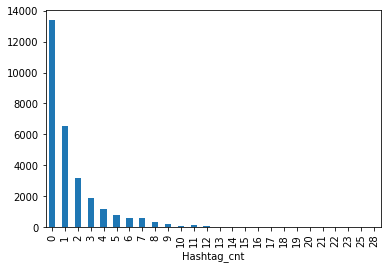

In [ ]:
train_df_with_hashtag_cnts.groupby('Hashtag_cnt').size().plot.bar()

In [ ]:
HASHTAG_PROB_CONTRIBUTIONS = 1 / train_hashtags_lengths.max()
HASHTAG_PROB_CONTRIBUTION

0.03571428571428571